In [52]:
import matplotlib.pyplot as plt
from math import sqrt, e

import csv
import numpy as np
import random
import seaborn as sns
from collections import Counter
from sklearn.metrics import ndcg_score

In [53]:
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

# Algorithms

## Differential Privacy

### DP

In [54]:
def laplace_mech(answer, sensitivity, epsilon):
    return answer + np.random.laplace(loc=0, scale=sensitivity / epsilon)

### LDP

#### DE

In [55]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [56]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]
    return random.choice(domain_q)

In [57]:
def randomized_responses_DE(responses, epsilon):
    d = len(responses)
    domain = [i for i in range(0, d)]
    p, q = DE_p_q(epsilon, d)

    noisy_responses = np.zeros(len(responses))

    for i in range(len(responses)):
        for j in range(responses[i]):
            sample = np.random.random()

            if sample <= p:
                #tell the truth
                #by adding to noisy_responses in the i position
                noisy_responses[i] = noisy_responses[i] + 1

            else:
                #lie
                #by adding to noisy_responses in any position but i 
                any_pos_but_i = random_pick_DE(domain, i)
                noisy_responses[any_pos_but_i] = noisy_responses[any_pos_but_i] + 1

    return noisy_responses

In [58]:
def adjustDE(noisy_responses, epsilon, n):
    d = len(noisy_responses)
    p, q = DE_p_q(epsilon, d)
    copy = noisy_responses.copy().astype(int)
    
    for i in range(len(copy)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copy[i] = a * copy[i] - b

    return copy

In [59]:
def DEresponses(responses, epsilon):
    n = sum(responses)
    return adjustDE(randomized_responses_DE(responses, epsilon), epsilon, n)

#### OUE

In [60]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

In [61]:
def OUEresponses(responses, epsilon):
    p, q = optimized_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p, q, n)  

#### UE

In [62]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [63]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [64]:
def perturb_onto_agg(responses, p , q):
    noisy_responses = np.zeros(len(responses))
    #print("SOMA: ",sum(responses))
    
    for i in range(len(responses)):
        #print("i",i)
        for j in range(responses[i]):
            #print("j",j)
            for k in range(len(noisy_responses)):
                #print("k",k)
                #works hence the internal for iterates each one time for a singular unit
                sample = np.random.random()
                
                #case bit is 1(same cell, therefore using p)
                if i == k:
                    #print("here")
                    if sample <= p:
                        #tell the turht
                        #by adding 1 to the i(k) position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else:
                        #lie
                        #by not adding anything to the vector
                #handles other cells(using q probability)
                else:
                    #print("there")
                    if sample <= q:
                        #lie
                        #by summing 1 onto the k position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else: 
                        #truth
                        #by omiting form it
    return noisy_responses

In [65]:
def adjustUE(noisy_responses, p, q, n):
    d = len(noisy_responses)
    copyUE = noisy_responses.copy().astype(int)
    
    for i in range(len(copyUE)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copyUE[i] = a * copyUE[i] - b

    return copyUE

In [66]:
def UEresponses(responses, epsilon):
    p, q = symetric_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p ,q, n)

## Preprocessing

In [67]:
def norm_sub(estimations, truth_total):
    f_tilde = np.array(estimations, dtype=float)  # Convert to a numpy array
    
    # Convert negative values to 0
    f_tilde[f_tilde < 0] = 0

    # Normalize f_tilde to sum to 1
    f_tilde /= f_tilde.sum()

    # Scale it back to the original total
    scaled_values = f_tilde * truth_total

    # Convert to integers and calculate the difference
    int_values = np.floor(scaled_values).astype(int)
    difference = truth_total - np.sum(int_values)

    # Distribute the remaining difference by adding 1 to some of the elements
    indices = np.argsort(scaled_values - int_values)[-difference:]  # Get the indices with the largest fractional part
    int_values[indices] += 1

    return int_values

In [160]:
#actual
def act_norm_sub(estimations, Truth_total):
    f_tilde = np.array(estimations, dtype=float)  # Convert to a numpy arra
    #print(f_tilde)
    #converts negative values to 0
    f_tilde[f_tilde < 0] = 0
    #print(f_tilde)

    for i in range(len(f_tilde)):
        f_tilde[i] /= Truth_total

    #print(f_tilde)
    #print(sum(f_tilde))
        
    #maintains overall sum to 1, adding delta to each REMAINING VALUE
    delta = 0
    while sum(f_tilde) < 1:
        non_zero_indices = f_tilde > 0  # Identify non-zero elements
        f_tilde[non_zero_indices] += delta
        delta += 1e-10  # Small delta to ensure convergence
    #print(f_tilde)
    #print(sum(f_tilde))
    
    return (f_tilde*Truth_total).astype(int)

## PSFO

In [68]:
# padding and sampling function
 #case cardinality of v is less than l adds l - |transaction| (dummy variables), dont belong to the items of transaction, so get random ones form the domain that dont belong to the transaction

 #then sample! That is: select AN element of trnasaction at a uniform random

#padds and samples, ,lol
def PS(l, transaction, domain):
    
    while len(transaction) < l:
        pool = [item for item in domain if item not in transaction]
        dummy = random.choice(pool)
        transaction.append(dummy)  #adds a dummy item from the domain pool
        #print(transaction)

    try:
        # Try to sample an item from the transaction
        sample = random.choice(transaction)
    except IndexError:
        # Catch error in case the transaction is empty or sampling fails
        print(f"Error: Could not sample from transaction. l = {l}, transaction = {transaction}, domain = {domain}")
    
    return sample

In [161]:
#Applies padding and sampling then an FO protocol
#To estimate the frequency of an item
#x, one obtains the frequency estimation of x from the FO
#protocol, and then multiplies it by l

#alsdo uses adaptive FO based on l and d

def PSFO(l, transactions, epsilon, domain):
    
    d = len(domain)

    #sum of total frequencies for preprocessing
    flattened_list = [item for sublist in transactions for item in sublist]
    item_counts = Counter(flattened_list)
    
    truth_total = sum(item_counts)
        
    #r = []
    r = np.zeros(d, dtype=int)
    
    #generates a list of size n, that is, n values, each coresponding to a padded and sampled transaction
    for transaction in transactions:
        #print("transaction",transaction)
        sample = PS(l, transaction, domain)
        #print("sample: ",sample)
        #r.append(sample)

        r += encode(sample, domain)

    #print("r :", r)
    #adaptive FO check
    if d < (l*(4*l - 1)*e**(epsilon) + 1):
        r_noise = DEresponses(r, epsilon)
    else:
        r_noise = OUEresponses(r, epsilon)

    
    #print("noise: ", r_noise)
    est = [item * l for item in r_noise]

    normsub_est = act_norm_sub(est, truth_total)
    
    return normsub_est 

## Cardinalities Reconstruction

In [70]:
def get_intersections_cardinalities(S, transactions, epsilon):
    
    intersection_cardinalities = []
    r = np.zeros(len(S) + 1, dtype=int)

    #intersection
    for transaction in transactions:
        intersection_cardinality = sum(item in S for item in transaction)
        intersection_cardinalities.append(intersection_cardinality)

    domain = list(range(0, len(S)+1))
    
    for cardinality in intersection_cardinalities:
        r += encode(cardinality, domain)

    r_noise = OUEresponses(r, epsilon)
    #print(intersection_cardinalities)
    return r

In [71]:
def reconstruct_cardinalities(r):
    return np.hstack([np.full(count, idx) for idx, count in enumerate(r)])

# BMS-POS and Kosarak

In [72]:
#as a list
user_transactions_BMS = []

with open('BMS-POS.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        user_transactions_BMS.append([int(item) for item in row if item])

#for idx, transaction in enumerate(user_transactions_BMS, start=0):
    #print(transaction)

In [73]:
distinct_items = set(item for transaction in user_transactions_BMS for item in transaction)

num_distinct_items = len(distinct_items)

print(f"Number of transactions: {len(user_transactions_BMS)}")
print(f"Number of distinct items: {num_distinct_items}")

Number of transactions: 515596
Number of distinct items: 1657


In [74]:
#as a list
user_transactions_Kor = []

with open('kosarak.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        user_transactions_Kor.append([int(item) for item in row if item])

#for idx, transaction in enumerate(user_transactions_Kor, start=1):
    #print(transaction)


In [75]:
distinct_items = set(item for transaction in user_transactions_Kor for item in transaction)

num_distinct_items = len(distinct_items)

print(f"Number of transactions: {len(user_transactions_Kor)}")
print(f"Number of distinct items: {num_distinct_items}")
#print(sorted(distinct_items))

Number of transactions: 990002
Number of distinct items: 41270


# SVIM

## Partitioning(groups)

In [76]:
def Partition_groups(user_transactions, p, percentage_1, percentage_2, percentage_3, percentage_4, percentage_5):
    total_users = len(user_transactions)
    
    item_group_size = int(total_users * p) #reserved group size for item estimations
    itemset_group_size = int(total_users - item_group_size)  #reserved group size for itemset estimations
    
    group_1_size = int(item_group_size * percentage_1)  #for candidates; S
    group_2_size = int(item_group_size * percentage_2)  #for; L
    group_3_size = int(item_group_size - (group_1_size + group_2_size) )  #estimation of S

    group_4_size = int(itemset_group_size * percentage_4)  #
    group_5_size = int(itemset_group_size - group_4_size)  #
    
    #shuffle list
    random.seed(42)  # For reproducibility
    shuffled_data = user_transactions_BMS.copy()
    random.shuffle(shuffled_data)
    
    #groups(items)
    group_1 = shuffled_data[:group_1_size]  
    group_2 = shuffled_data[group_1_size:group_1_size + group_2_size]  
    group_3 = shuffled_data[group_1_size + group_2_size:group_1_size + group_2_size + group_3_size]  

    #groups(itmesets)
    group_4 = shuffled_data[group_1_size + group_2_size + group_3_size:group_1_size + group_2_size + group_3_size + group_4_size]
    group_5 = shuffled_data[group_1_size + group_2_size + group_3_size + group_4_size:group_1_size + group_2_size + group_3_size + group_4_size + group_5_size]

    return group_1, group_2, group_3, group_4, group_5 

In [77]:
g1,g2,g3,g4,g5 = Partition_groups(user_transactions_BMS, 0.5, 0.5,0.1,0.4, 0.1, 0.9)

print(len(g1))
print(len(g2))
print(len(g3))

print(len(g1) +len(g2) +len(g3) +len(g4) +len(g5))

128899
25779
103120
515596


In [78]:
g1,g2,g3,g4,g5 = Partition_groups(user_transactions_BMS, 1, 0.5,0.1,0.4, 0.1, 0.9)

print(len(g1))
print(len(g2))
print(len(g3))
print(len(g4))
print(len(g5))

print(len(g1) +len(g2) +len(g3) +len(g4) +len(g5))

257798
51559
206239
0
0
515596


In [79]:
def get_domain(user_transactions):
    return set(item for transaction in user_transactions_BMS for item in transaction)

In [80]:
domain = get_domain(user_transactions_BMS)
print(domain)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

## Prune the domain (Step 1)

In [81]:
def Candidates_SVIM(k, transactions, epsilon, domain):
    
    l = 1
    r = PSFO(l, transactions, epsilon, domain)

    #top values 
    top_2k_values = np.sort(np.unique(r))[-2*k:][::-1]
    top_2k_indices = [np.where(r == value)[0] for value in top_2k_values]
    
    S = [int(arr[0]) if not isinstance(arr, int) else arr for arr in top_2k_indices]

    return S

In [84]:
S = Candidates_SVIM(10, g1, 5, domain)

In [85]:
print(S)

[3, 35, 8, 9, 33, 30, 1, 10, 37, 63, 42, 81, 34, 36, 172, 65, 11, 60, 139, 62]


In [86]:
all_items = [item for transaction in user_transactions_BMS for item in transaction]

item_counts = Counter(all_items)

most_common_items = item_counts.most_common(20)

most_common_items_vector = [item for item, count in most_common_items]

print("REAL TOP 20 ITEMS :", most_common_items_vector)
print("CANDIDATES:        ", S)
print("ITEMS GOT RIGHT:   ", set(S).intersection(most_common_items_vector))
print("ITEMS GOT WRONG:   ", set(S) - set(most_common_items_vector), " instead of " ,set(most_common_items_vector) - set(S).intersection(most_common_items_vector))


REAL TOP 20 ITEMS : [3, 8, 35, 9, 1, 30, 33, 42, 10, 34, 36, 37, 63, 23, 65, 81, 172, 62, 53, 11]
CANDIDATES:         [3, 35, 8, 9, 33, 30, 1, 10, 37, 63, 42, 81, 34, 36, 172, 65, 11, 60, 139, 62]
ITEMS GOT RIGHT:    {1, 33, 35, 3, 34, 36, 37, 8, 9, 42, 10, 65, 172, 11, 81, 62, 30, 63}
ITEMS GOT WRONG:    {139, 60}  instead of  {53, 23}


## Size Estimation (Step 2)

In [87]:
def L_SVIM(S, percentile, transactions, epsilon):

    r = get_intersections_cardinalities(S, transactions, epsilon)
    estimated_cardinalities = reconstruct_cardinalities(r)

    L = np.percentile(estimated_cardinalities, percentile)

    if int(L) == 0:
        L = 1

    return int(L)

In [89]:
L = L_SVIM(S, 90, g2, 5)
print(L)

6


## Candidate Estimation (Step 3)

In [90]:
def Candidates_est_SVIM(S, L, transactions, epsilon):

    intersections = []

    for transaction in transactions:
        intersection = list(set(transaction).intersection(S))
        #print(intersection)
        #saves all the intersection
        #virtually replacing the transactions list of list to a
        #list of intersections for each transaction with S
        intersections.append(intersection)
    #print(intersections)
    #print(len(intersections))

    domain = S
    #print(domain)
    #print(len(domain))
    
    r = PSFO(L, intersections, epsilon, domain)
    #print(intersections)
    return r

In [92]:
epsilon = 0.2
k = 64
L = 6
S = [3, 735, 799, 541, 925, 662, 798, 885, 630, 301, 336, 1041, 707, 936, 47, 703, 592, 84, 1118, 1033, 121, 911, 492, 650, 33, 1019, 859, 588, 40, 578, 982, 606, 143, 54, 278, 1210, 648, 514, 82, 845, 1397, 267, 103, 73, 428, 37, 420, 233, 215, 197, 1288, 223, 1246, 71, 981, 823, 164, 1007, 1105, 742, 30, 1385, 590, 1071, 445, 208, 440, 198, 174, 14, 178, 1070, 761, 1155, 871, 7, 866, 679, 247, 443, 1222, 746, 1082, 15, 241, 920, 847, 255, 295, 564, 221, 479, 1253, 58, 979, 303, 52, 1293, 302, 504, 10, 239, 387, 77, 1022, 9, 892, 338, 896, 954, 461, 100, 512, 179, 751, 446, 231, 631, 67, 110, 65, 491, 439, 560, 275, 368, 655, 570]

r = Candidates_est_SVIM(S, L, g3, epsilon)
print(r)
print(len(r))

[ 842  261  261 2157 2738    0    0    0   17   47  689    0 1240    0
    0    0  414    0    0 1148    0    0    0  322 1974    0    0    0
 1056  261  139 2371 1515    0    0 1454 1790    0 1913  322 1179    0
 2799  689  108    0  781    0 1393    0    0 1729    0    0  995 1943
    0    0  445    0    0    0    0    0  689  689    0    0 1270  292
  536  200    0    0  781    0  506  842  108    0    0  750    0  139
    0    0 1423 1301  322 1393  261 1484  139    0  659    0    0    0
    0  292 2127 1729    0  414    0    0  628  781 1301    0    0    0
 2830    0    0    0  231    0 1209  139    0  231  261  445    0  292
    0    0]
128


## Estimation Update (Step 4)

In [93]:
def Estimation_update_SVIM(L, S, transactions, epsilon):

    agg_cardinalities = get_intersections_cardinalities(S, transactions, epsilon)
    #print(agg_cardinalities)
    #disregards l = 0(no intersection position)
    adj_fact1 = sum(agg_cardinalities[1:])
    adj_fact2 = []
    
    for i in range(L+1, len(S)+1):
        adj_fact2.append( (i-L)*agg_cardinalities[i])

    u = adj_fact1 / (adj_fact1 - sum(adj_fact2))

    return u

In [94]:
print(Estimation_update_SVIM(6, S, user_transactions_BMS, 10))
print(Estimation_update_SVIM(6, S, g2, 10))

1.0418816824824197
1.039125221561881


## SVIM vanilla

In [95]:
def SVIM(user_transactions, group_1, group_2, group_3, k, epsilon, domain):

    #step 1(finds candidates)
    S = Candidates_SVIM(k, group_1, epsilon, domain)
    #print("\033[1mCandidates:\033[0m ", S)

    #step 2(estimates size)
    percentile = 90
    L = L_SVIM(S, percentile, group_2, epsilon)
    #print("\033[1mEstimated Size(L):\033[0m ", L)

    #step 3(estimates frequencies of said candidates)
    est_frequencies = Candidates_est_SVIM(S, L, group_3, epsilon)
    #print("\033[1mEstimated Frequencies:\033[0m ", est_frequencies)

    #step 4(estimation update)
    update_factor = Estimation_update_SVIM(L, S, user_transactions, epsilon)
    #print("\033[1mUpdate Factor:\033[0m ", update_factor)

    #update
    est_frequencies_updated = [int(item * update_factor) for item in est_frequencies]
    #print("\033[1mUpdated Estimated Frequencies:\033[0m ", est_frequencies_updated)

    ## Rearange order according to new estimations and return 2 lists, the items and their frequencies accondinly
    # Zip the lists together and sort by the values in b (in descending order)
    zipped_lists = sorted(zip(est_frequencies_updated, S), reverse=True)
    
    items_frequencies, frequent_items = zip(*zipped_lists)
    
    items_frequencies = list(items_frequencies)
    frequent_items = list(frequent_items)
    
    #print("\033[1mSorted a:\033[0m ", items_frequencies)
    #print("\033[1mSorted b:\033[0m ", frequent_items)

    return S, est_frequencies_updated

In [169]:
g1,g2,g3,g4,g5 = Partition_groups(user_transactions_BMS, 0.5, 0.5,0.1,0.4, 0.1, 0.9)

print(len(g1))
print(len(g2))
print(len(g3))
print(len(g4))
print(len(g5))

print(len(g1) +len(g2) +len(g3) +len(g4) +len(g5))

128899
25779
103120
25779
232019
515596


In [106]:
domain = get_domain(user_transactions_BMS)

In [107]:
S, F = SVIM(user_transactions_BMS, g1, g2, g3, 10, 3, domain)

print("Estimated Top k items: ", S)
print("Frequencies of Estimated Top k items: ", F)

Estimated Top k items:  [3, 35, 9, 8, 30, 33, 1, 37, 36, 10, 42, 34, 63, 81, 172, 11, 139, 23, 83, 217]
Frequencies of Estimated Top k items:  [149, 84, 74, 82, 64, 62, 69, 57, 59, 64, 62, 61, 59, 56, 53, 56, 52, 58, 52, 47]


In [99]:
def ground_truth(user_transactions, k):
    k = 2*k
    flattened_list = [item for sublist in user_transactions_BMS for item in sublist]

    item_counts = Counter(flattened_list)
    
    top_k_items = item_counts.most_common(k)
    
    # Separate items and frequencies into two vectors (lists)
    items = [item for item, _ in top_k_items]
    frequencies = [frequency for _, frequency in top_k_items]

    return items, frequencies

In [100]:
St, Ft = ground_truth(user_transactions_BMS, 10)
print("Top k items: ", St)
print("Frequencies of Top k Items: ", Ft)

Top k items:  [3, 8, 35, 9, 1, 30, 33, 42, 10, 34, 36, 37, 63, 23, 65, 81, 172, 62, 53, 11]
Frequencies of Top k Items:  [308656, 116102, 115691, 89331, 74959, 60046, 57414, 55174, 53664, 48505, 41254, 40062, 39998, 39723, 38986, 38473, 37762, 34842, 32818, 31692]


# Metrics (NCR and Var)

## NCR

In [102]:
def create_quality_function(xt, k):
    # Generate scores based on k
    scores = [max(k - i, 0) for i in range(len(xt))]
    
    # Create a mapping function
    def quality_function(value):
        if value in xt:
            index = xt.index(value)
            return scores[index]
        else:
            return 0  # Return 0 if the value is not in xt
    
    return quality_function

In [103]:
def NCR(xr, xt, k):
    
    qr_sum = 0
    qt_sum = 0

    quality_function = create_quality_function(xt, k)
    
    for item in xr:
        qr_sum += quality_function(item)
        #print("item", item)
        #print("value", quality_function(item))

    #print("-------------------------")
    for item in xt:
        qt_sum += quality_function(item)
        #print("item", item)
        #print("value", quality_function(item))

    qr_sum = qr_sum/( k*(k+1)/2)
    qt_sum = qt_sum/( k*(k+1)/2)
    
    NCG = qr_sum/qt_sum

    return NCG

In [104]:
xr = [2, 4, 11, 7, 77, 777]
xt = [2, 4, 11, 7, 77, 773]
k = 6

NCR(xr, xt, k)

0.9523809523809523

## testing

In [ ]:
true_relevance = np.asarray([[3, 2, 3, 0, 1, 2]])
predicted_scores = np.asarray([[2, 3, 3, 1, 2, 0]])

# Calculate NDCG (normalized discounted cumulative gain)
ndcg = ndcg_score(true_relevance, predicted_scores, k=5)

print(f"NDCG: {ndcg}")

In [ ]:
def ncg_score(y_true, y_pred, k=None):
    """
    Calculate the Normalized Cumulative Gain (NCG) without discounting.
    """
    # Convert input arrays to numpy format
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Sort true values based on predictions (descending order)
    indices = np.argsort(y_pred)[::-1]
    sorted_true = y_true[indices]
    
    # Calculate the cumulative gain (CG) at k
    if k:
        sorted_true = sorted_true[:k]
    cg = np.sum(sorted_true)
    
    # Calculate the ideal cumulative gain (ICG) at k (best possible score)
    ideal_sorted_true = np.sort(y_true)[::-1]
    if k:
        ideal_sorted_true = ideal_sorted_true[:k]
    icg = np.sum(ideal_sorted_true)
    
    # Return the normalized cumulative gain
    return cg / icg if icg > 0 else 0.0

# Example data
true_relevance = [3, 2, 3, 0, 1, 2]  # Ground truth relevance scores
predicted_scores = [2, 3, 3, 1, 2, 0]  # Predicted relevance scores

# Compute NCG@k
k = 5
ncg = ncg_score(true_relevance, predicted_scores, k)
print(f"NCG@{k}: {ncg}")

## Variance

In [145]:
# n is the number of users, thereby transaction
# fx is the frequency the itemset

def Var(xr, xt, candidates_estimation, real_frequencies, n):

    succ_identified = ( list(set(xr).intersection(xt)) )
    #print(succ_identified)
    summation = 0
    
    for item in succ_identified:
        #for the items in the intersection(aka the heavy hitter sucesfully identified)
        #calculate the difference between the actual frequency and the estimated one
        #square it up
        #print(item)
        xr_index = xr.index(item)
        #print(xr_index)
        xt_index = xt.index(item)
        #print(xt_index)
        # Retrieve the corresponding frequencies
        fx = real_frequencies[xt_index]  # Frequency from the real frequencies list
        phi = candidates_estimation[xr_index]  # Estimated frequency
        summation += (fx - phi)**2

    return (1/len(succ_identified))*summation if succ_identified else 0

In [146]:
xr = [2, 4, 5, 7, 1, 0]
xt = [2, 3, 5, 8, 88, 41]
n = 10

candidates_estimation = [0, 1, 88, 3, 77, 66, 0, 2, 0, 2]
real_frequencies = [6, 73213123213, 76, 9, 68, 58, 0, 2, 0, 2]

print(Var(xr, xt, candidates_estimation, real_frequencies, n))

90.0


In [171]:
#test 
epsilon = 4
k = 64
n = len(user_transactions_BMS)

#ground truth
St, Ft = ground_truth(user_transactions_BMS, k)
print("St: ", St)
print(len(St))

print("\nFt: ", Ft)
print(len(Ft))

#estimation

S, F = SVIM(user_transactions_BMS, g1, g2, g3, k, epsilon, domain)
print("S: ", S)
print(len(S))

print("\nF: ", F)
print(len(F))

metric1 = NCR(S, St, k)
metric2 = Var(S, St, F, Ft, n)

print(metric1)
print(metric2)

St:  [3, 8, 35, 9, 1, 30, 33, 42, 10, 34, 36, 37, 63, 23, 65, 81, 172, 62, 53, 11, 70, 92, 109, 60, 139, 229, 74, 61, 86, 98, 83, 16, 17, 157, 96, 127, 145, 241, 64, 28, 47, 173, 217, 270, 233, 242, 59, 89, 19, 99, 136, 156, 184, 186, 24, 29, 210, 194, 12, 246, 32, 251, 146, 222, 227, 307, 68, 104, 18, 129, 161, 105, 334, 82, 268, 273, 137, 250, 122, 306, 26, 240, 71, 2, 57, 85, 288, 180, 112, 118, 95, 38, 134, 14, 317, 79, 94, 0, 327, 58, 132, 125, 215, 143, 76, 116, 7, 206, 43, 320, 164, 168, 148, 31, 282, 152, 326, 289, 281, 257, 191, 255, 102, 66, 80, 335, 258, 130]
128

Ft:  [308656, 116102, 115691, 89331, 74959, 60046, 57414, 55174, 53664, 48505, 41254, 40062, 39998, 39723, 38986, 38473, 37762, 34842, 32818, 31692, 30018, 28624, 28108, 27213, 27071, 26356, 25789, 25573, 24177, 23417, 21928, 21686, 20945, 19830, 19783, 19096, 19045, 18765, 17522, 17297, 15927, 15859, 15279, 15198, 14381, 14332, 14133, 13943, 13792, 13685, 13517, 13350, 12917, 12901, 12794, 12609, 12557, 12451, 124

In [177]:
metric2/10**8

6.6351145684536075

# Analysis

In [178]:
# doe sth eexperiment n times
def experiment(user_transactions, group_1, group_2, group_3, k, epsilon, domain, times):
    
    ncr_results = []
    var_results = []

    n = len(user_transactions)

    for i in range(times):
        #ground truth
        St, Ft = ground_truth(user_transactions, k)
    
        #estimation
        S, F = SVIM(user_transactions, group_1, group_2, group_3, k, epsilon, domain)
    
        ncr = NCR(S, St, k)
        var = Var(S, St, F, Ft, n)
    
        ncr_results.append(ncr)
        var_results.append(var)
    
    mean_ncr = sum(ncr_results)/times
    mean_var = sum(var_results)/times
    
    return mean_ncr, mean_var

In [285]:
#testing group partitionning 
def comparator_partitioning(start, final, pace, pace_prctg, user_transactions, k, times):
    
    epsilon_values = list(np.arange(0, final + pace, pace))
    epsilon_values[0] = start
    
    ncr_lists = []
    var_lists = []

    domain = get_domain(user_transactions)

    percentages_1 = [round(num, 1) for num in list(np.arange(0.10, 0.90 + pace_prctg, pace_prctg))]
    percentages_1 = np.clip(percentages_1, 0.1, 0.9).tolist()

    #for each partition calculate, using the range of budgets, the results, end iwll ahve a alsit of lsits, eahc element of the lsits being the corresponding partition results
    for j in percentages_1:
        #calc percentages of other groups
        percentage_2 = round((1 - j)*0.2, 2)
        percentage_3 = round((1 - j)*0.8, 2)
        
        #gets partitioning
        group_1, group_2, group_3,_,_ = Partition_groups(user_transactions, 0.50, j, percentage_2, percentage_3, 0.1, 0.9)

        temp_ncr_values = []
        temp_var_values = []
        
        for i in epsilon_values:
            epsilon = i
        
            mean_ncr, mean_var = experiment(user_transactions, group_1, group_2, group_3, k, epsilon, domain, times)
        
            temp_ncr_values.append(mean_ncr)
            temp_var_values.append(mean_var)

        ncr_lists.append(temp_ncr_values)
        var_lists.append(temp_var_values)


    colors = plt.cm.viridis(np.linspace(0, 1, len(ncr_lists)))

    # Plot NCR values
    plt.figure(figsize=(24, 8))
    for idx, (ncr_values, color) in enumerate(zip(ncr_lists, colors)):
        plt.plot(epsilon_values, ncr_values, marker='o', alpha=0.9, color=color, label=f'Percentage of group_1 (S){percentages_1[idx]}')
    
    plt.title('POS, NCR, vary epsilon, k = 64')
    plt.xlabel('epsilon')
    plt.ylabel('ncr')
    plt.legend()

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

    # Plot Var values
    plt.figure(figsize=(24, 8))
    for idx, (var_values, color) in enumerate(zip(var_lists, colors)):
        plt.plot(epsilon_values, var_values, marker='+', alpha=0.9, color=color, label=f'Percentage of group_1 (S){percentages_1[idx]}')
    
    plt.title('POS, Var, vary epsilon, k = 64')
    plt.xlabel('epsilon')
    plt.ylabel('var')
    plt.yscale('log')
    plt.legend()

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

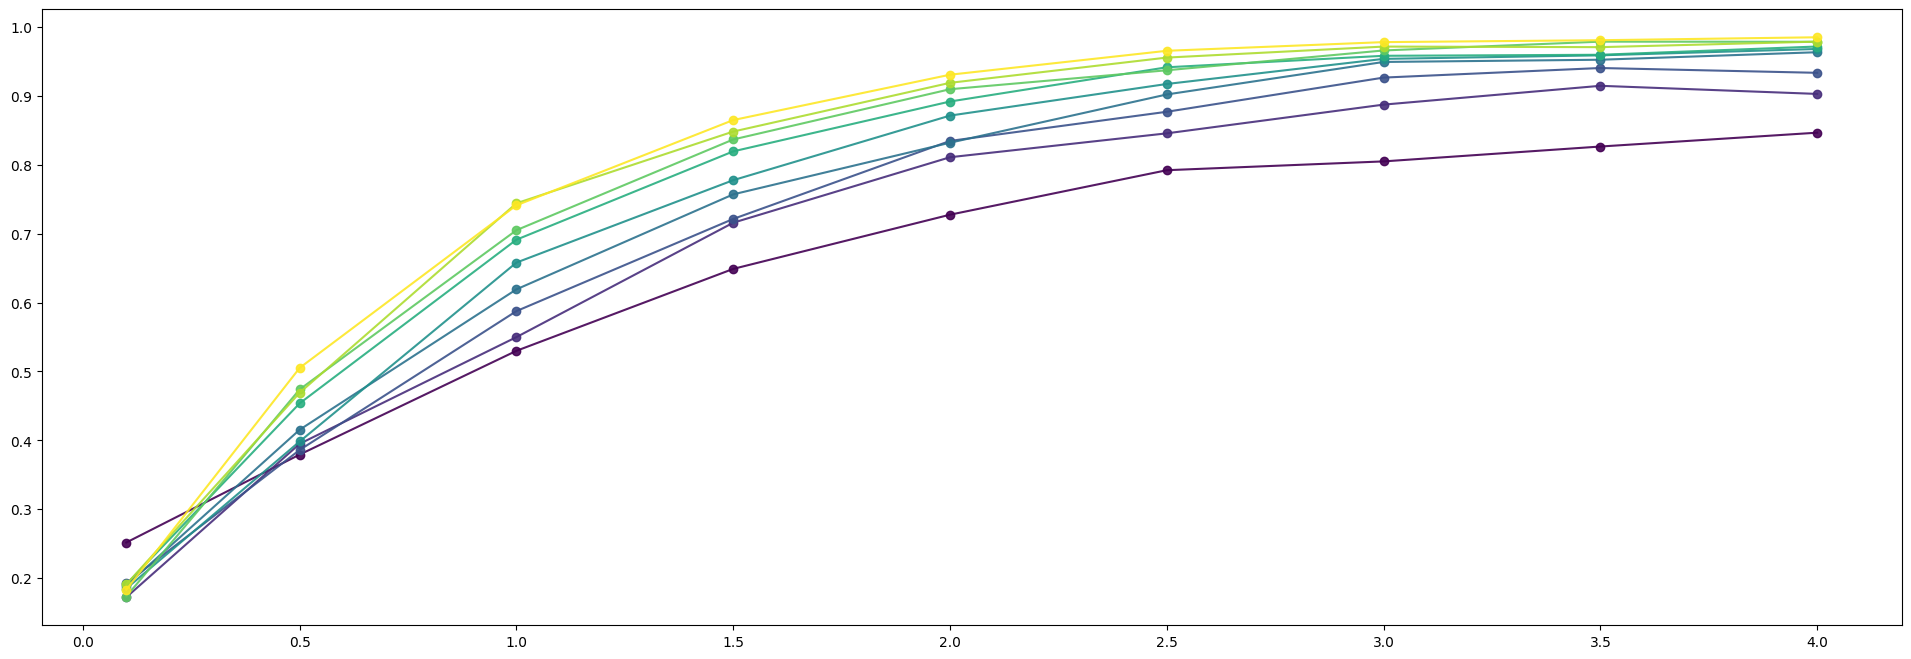

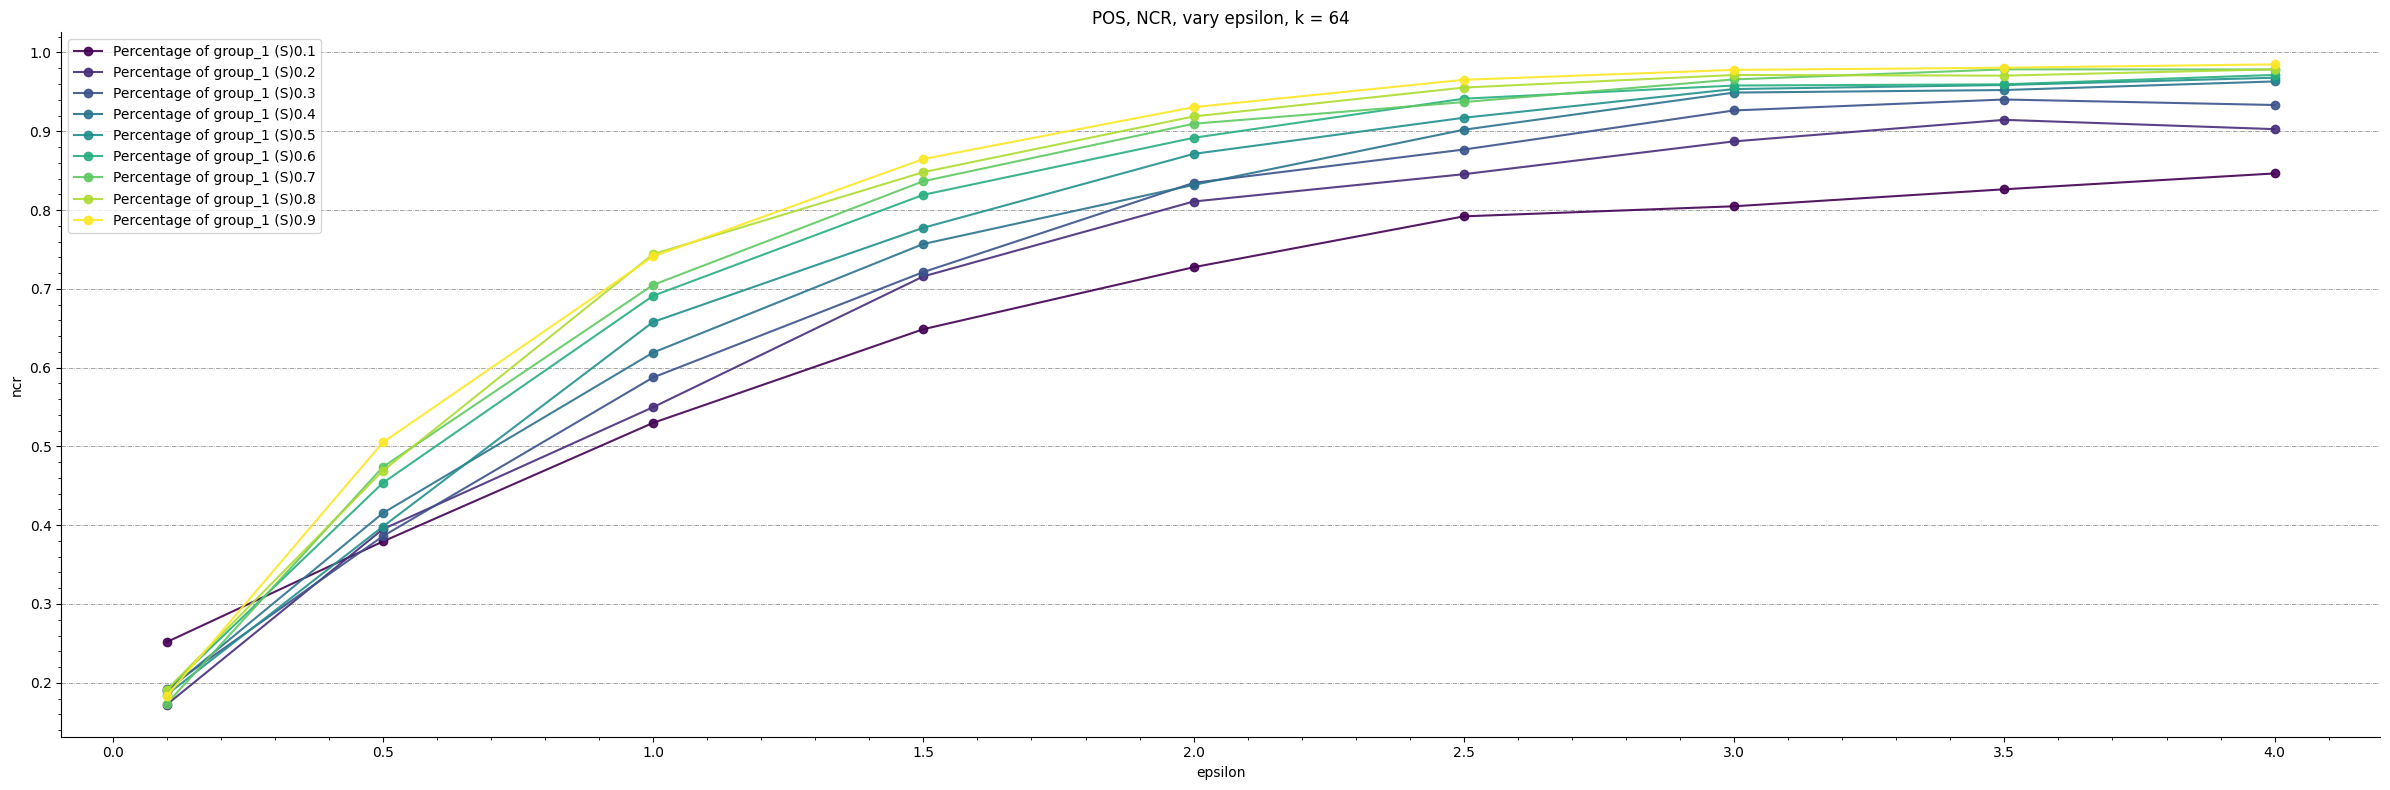

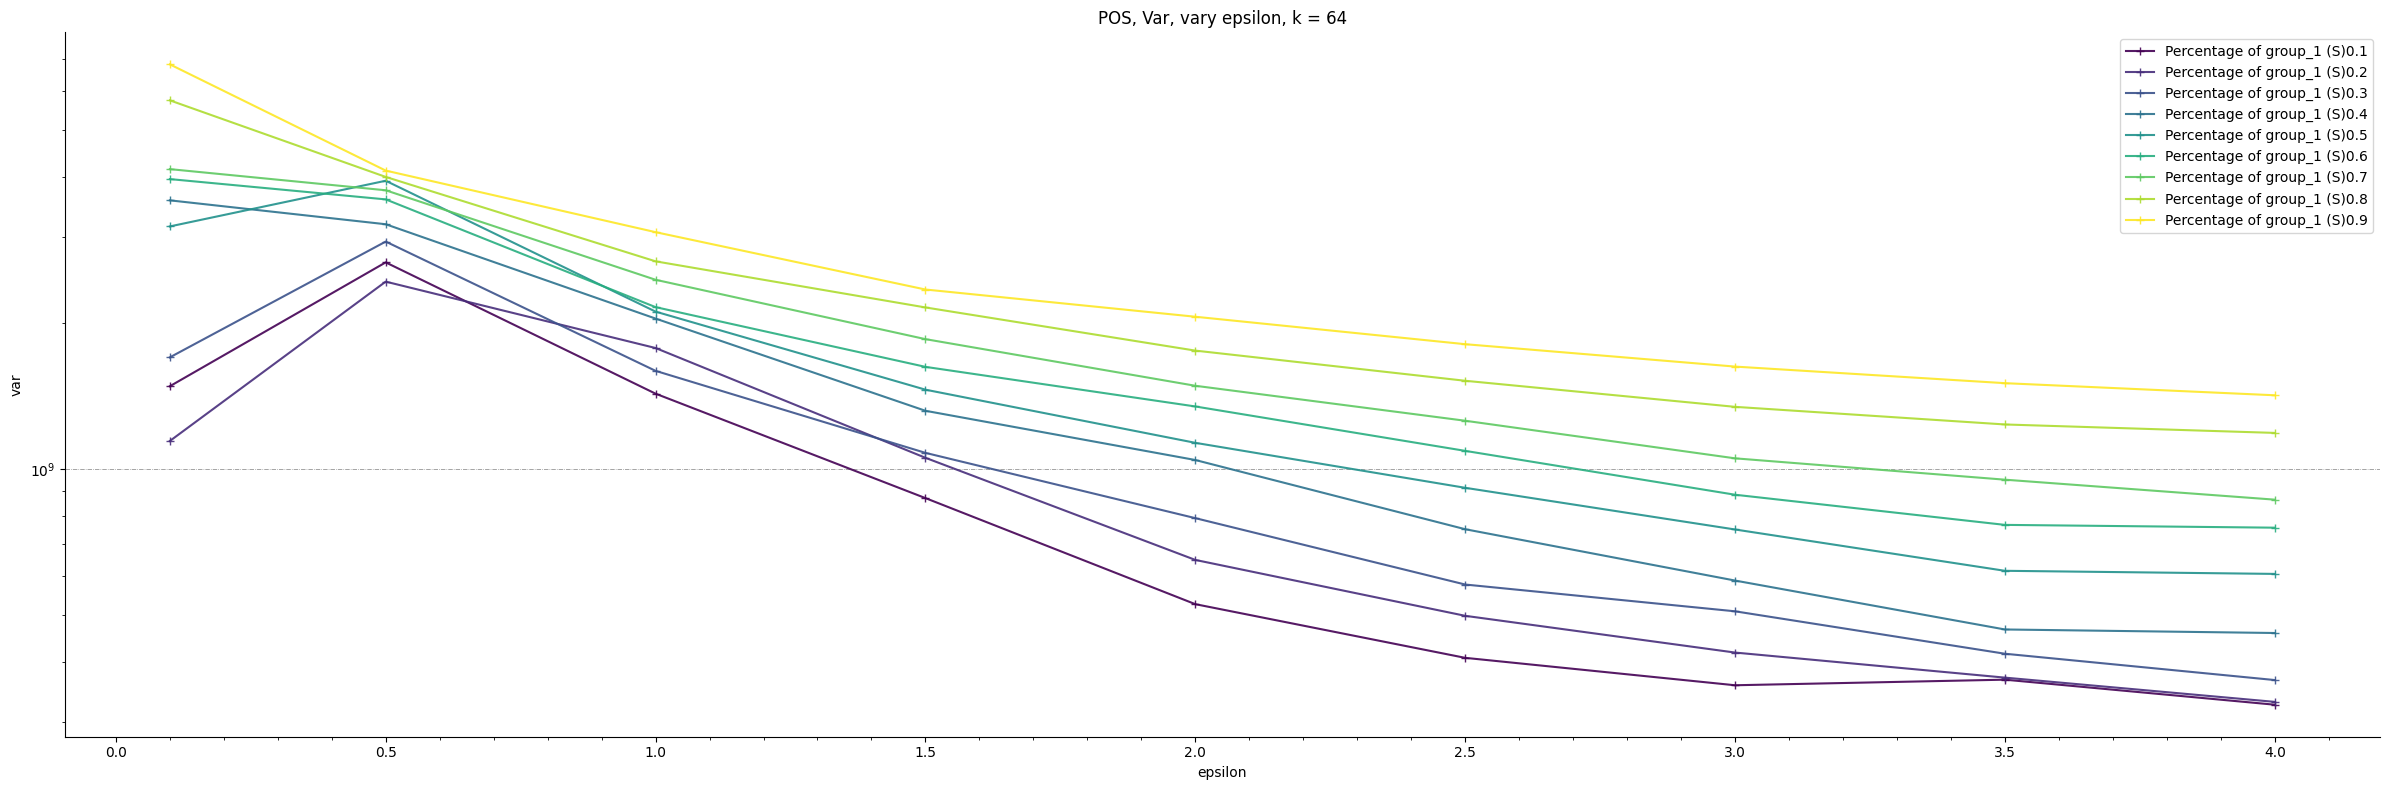

In [281]:
comparator_partitioning(0.1, 4, 0.5, 0.1, user_transactions_BMS, 64, 10)

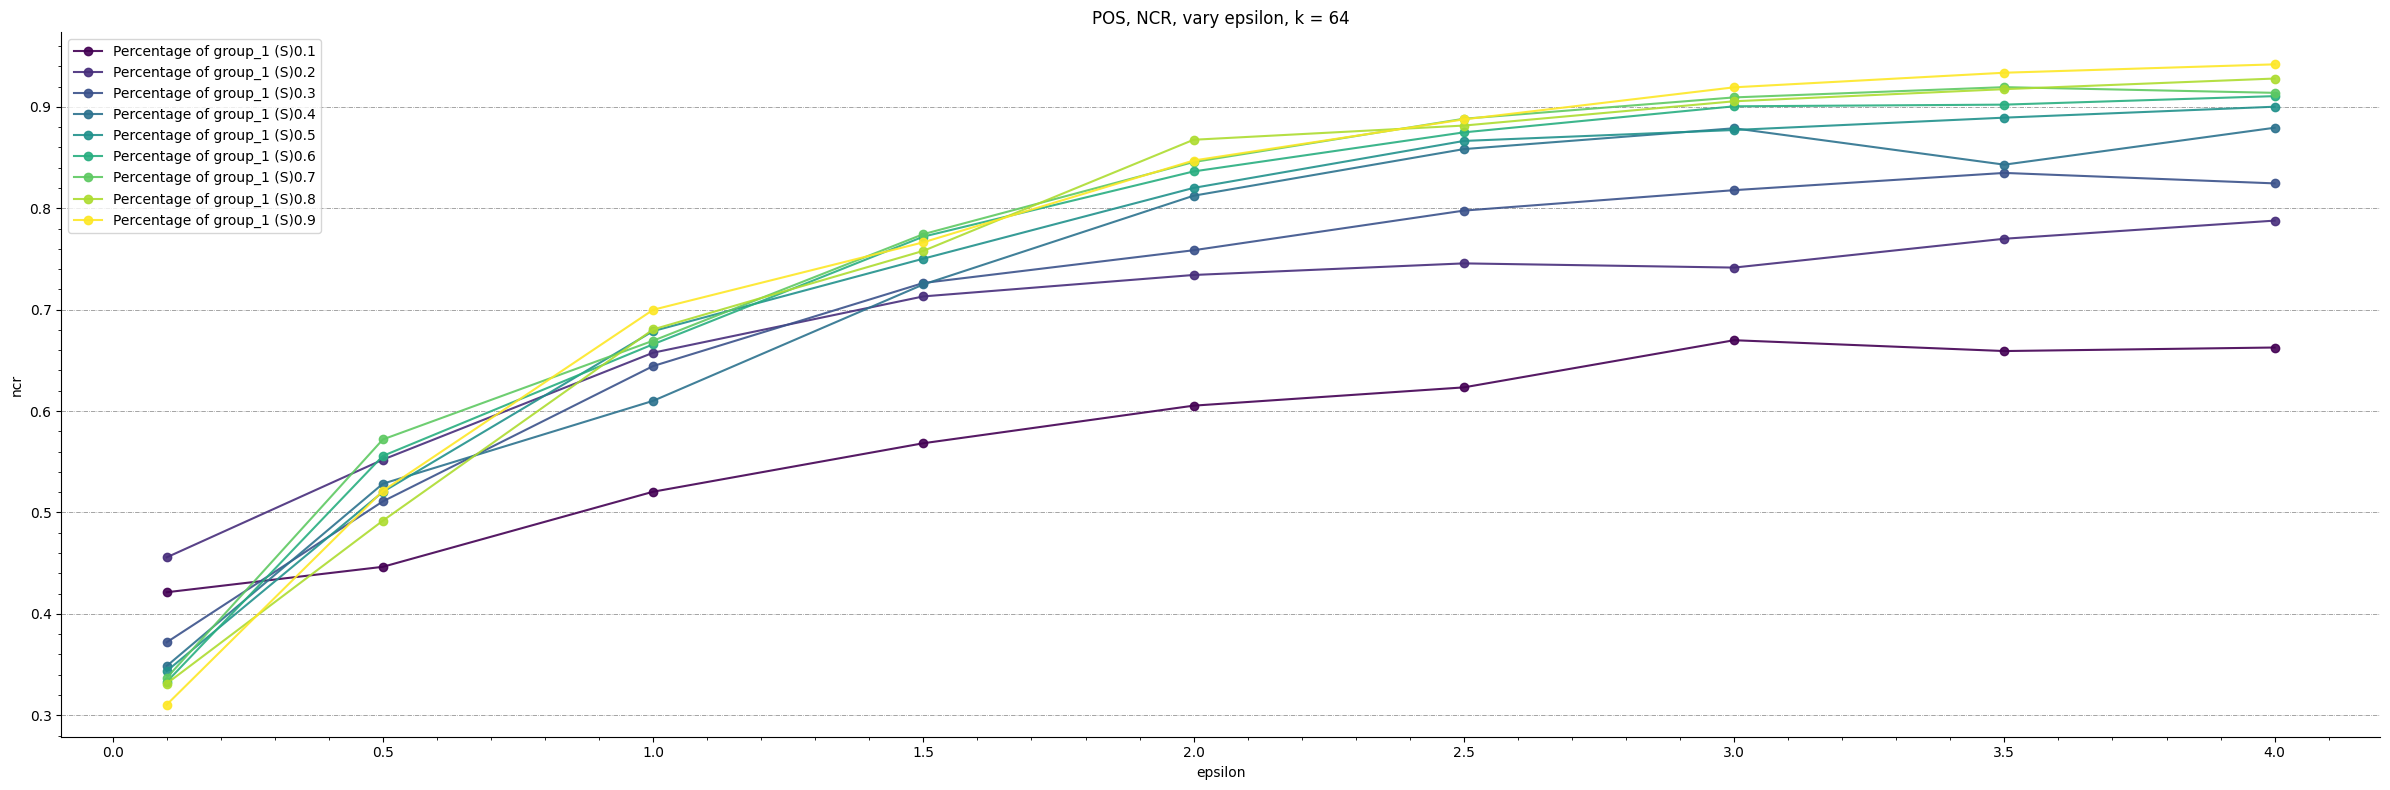

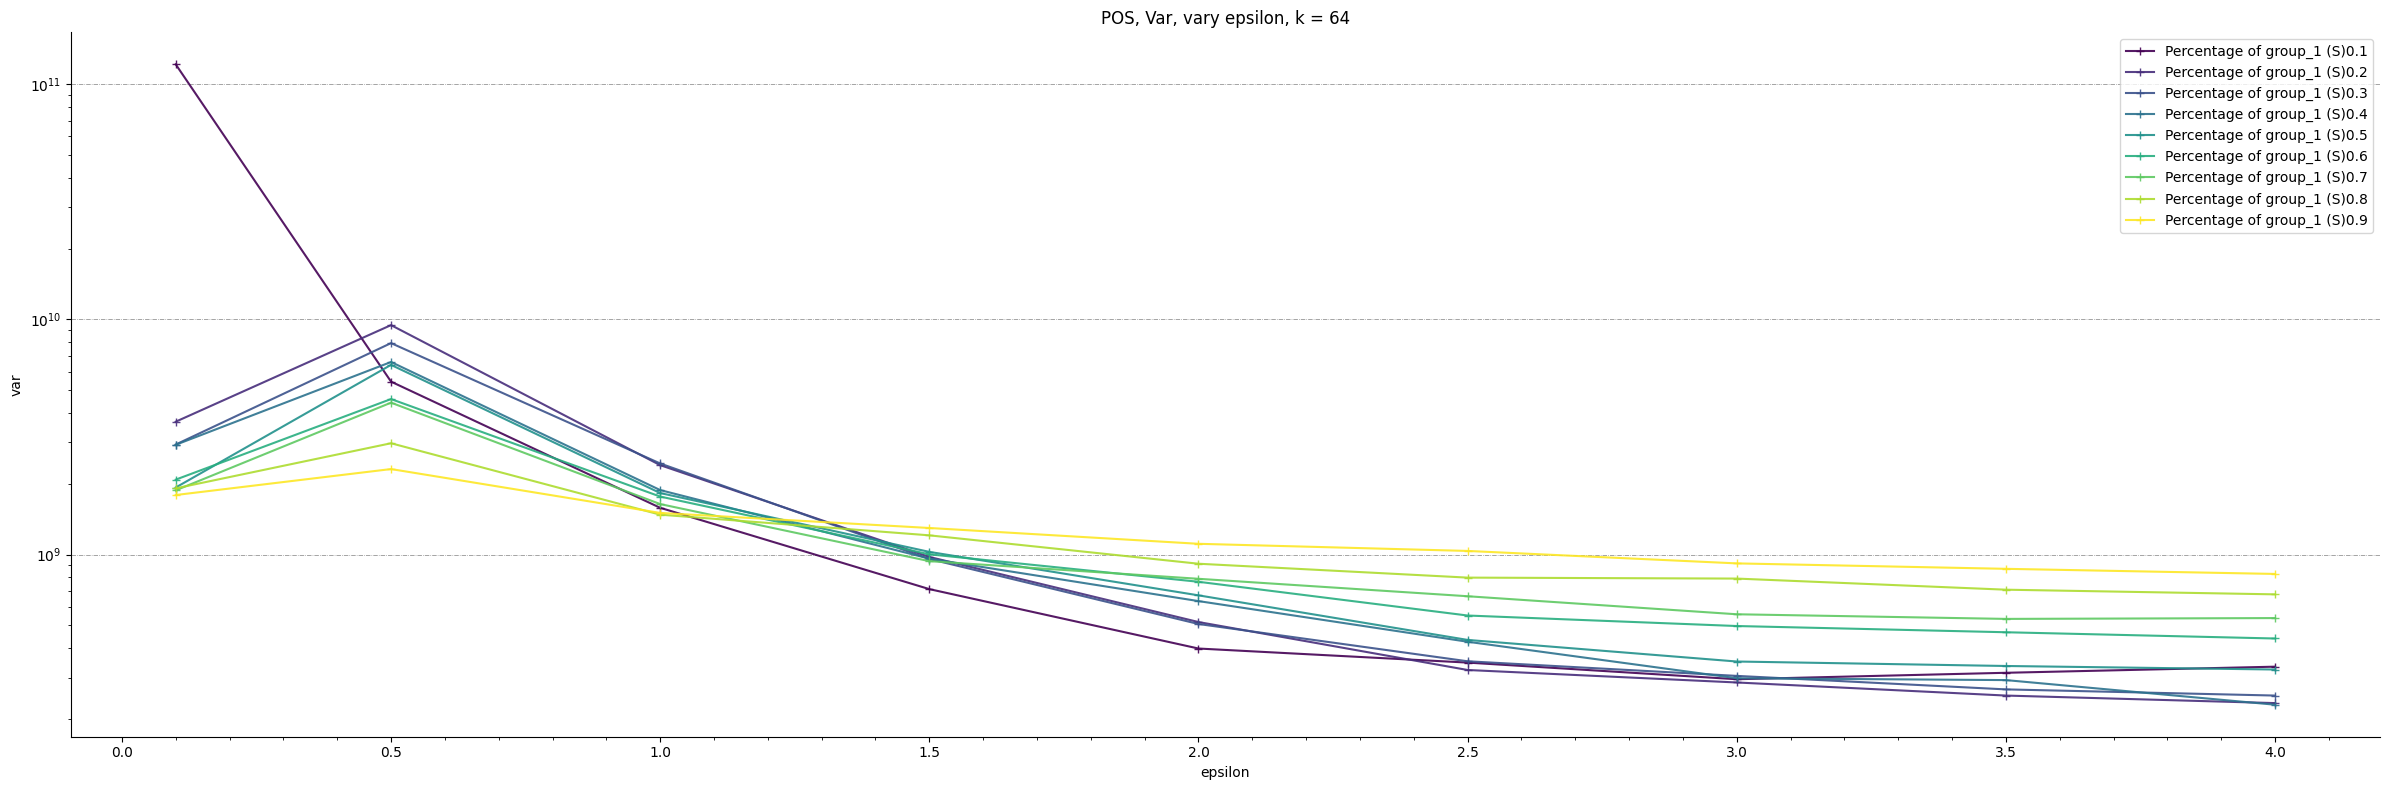

In [286]:
comparator_partitioning(0.1, 4, 0.5, 0.1, user_transactions_BMS, 128, 5)

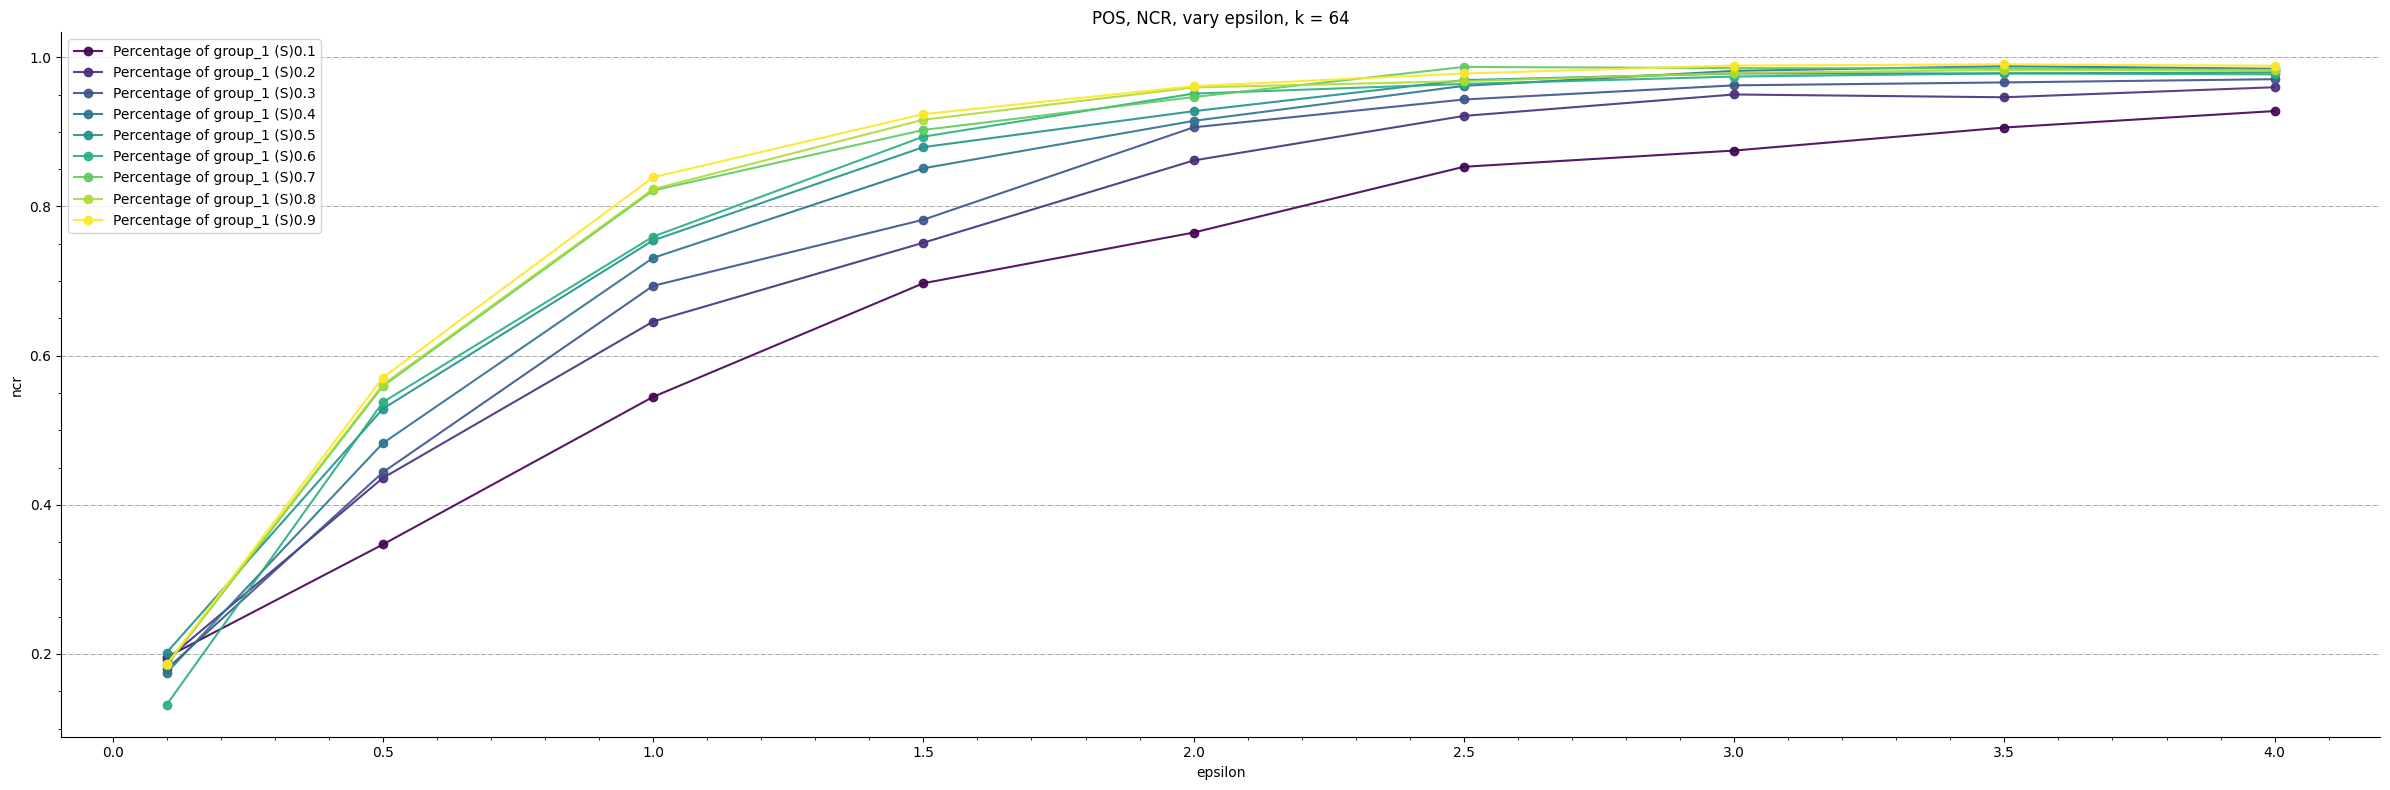

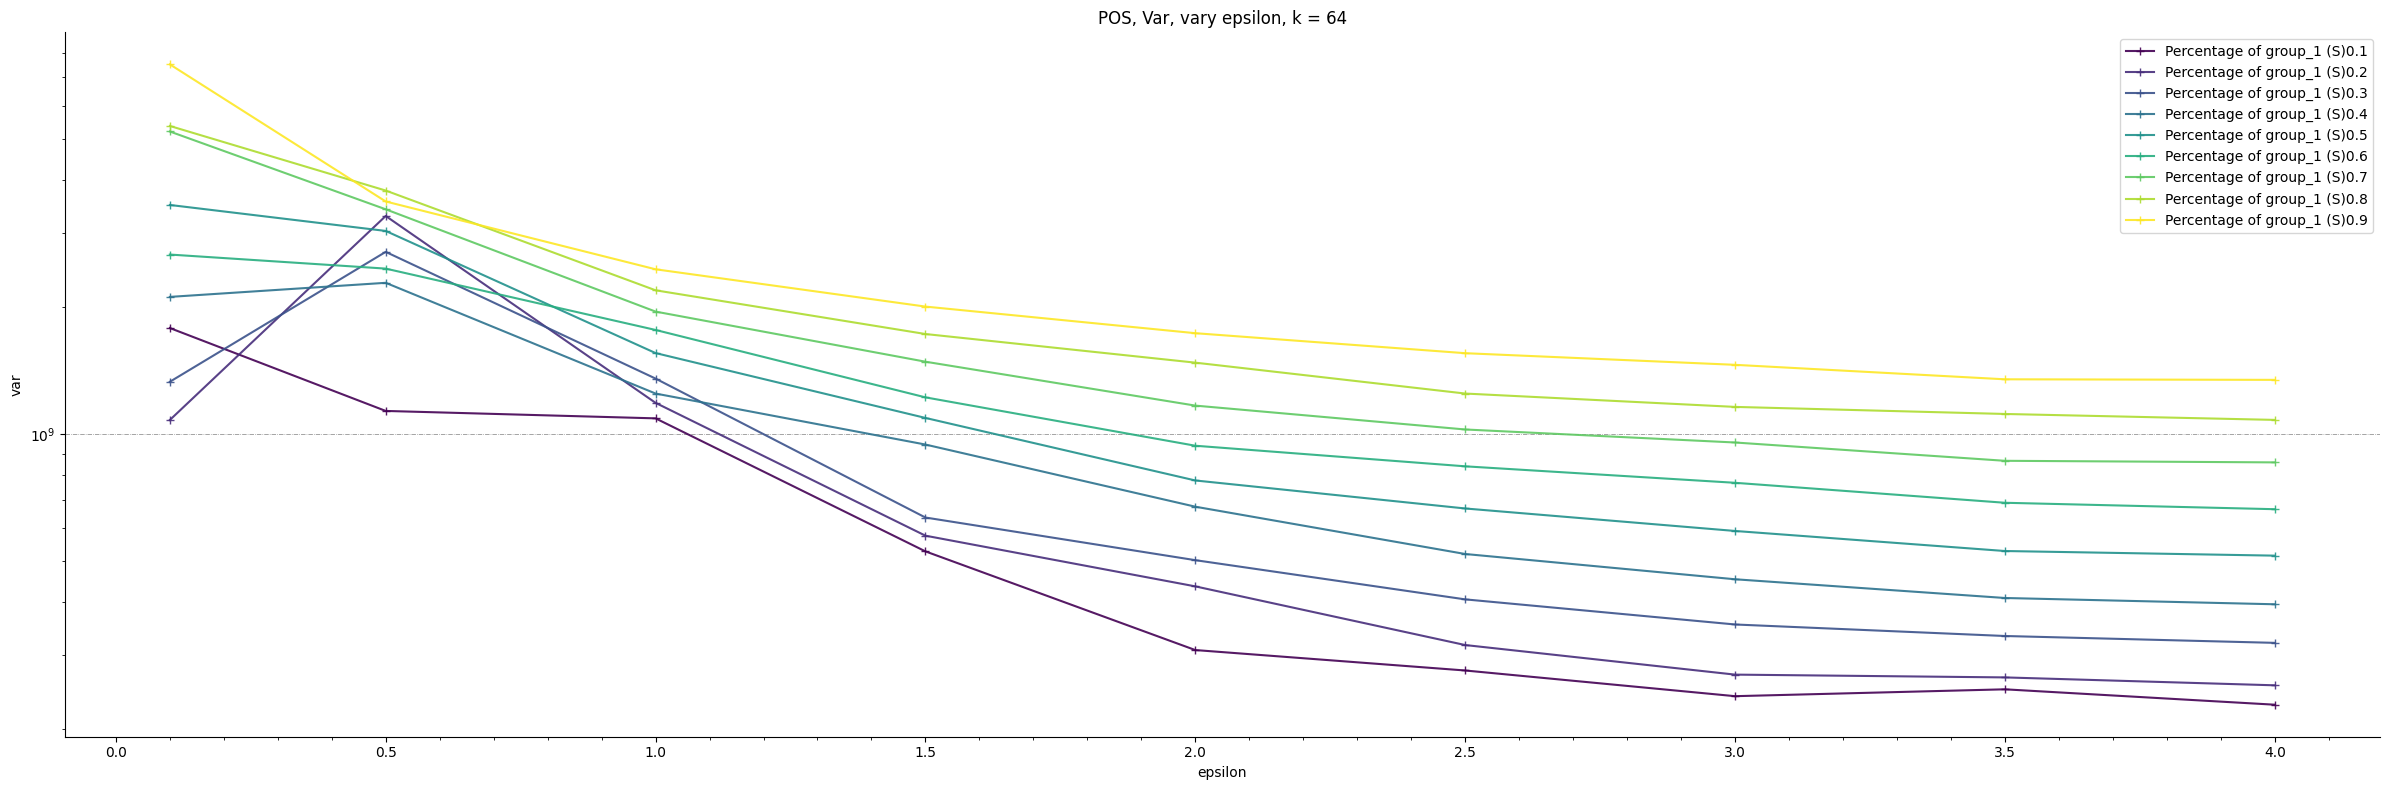

In [287]:
comparator_partitioning(0.1, 4, 0.5, 0.1, user_transactions_Kor, 64, 5)

In [288]:
comparator_partitioning(0.1, 4, 0.5, 0.1, user_transactions_Kor, 128, 5)

KeyboardInterrupt: 

In [287]:
def comparator(start, final, pace, user_transactions, group_1, group_2, group_3, k, domain, times):

    values = list(np.arange(0, final + pace, pace))
    values[0] = start

    ncr_values = []
    var_values = []
    epsilon_values = []
    
    for i in values:
        epsilon = i
        mean_ncr, mean_var = experiment(user_transactions, group_1, group_2, group_3, k, epsilon, domain, times)
    
        ncr_values.append(mean_ncr)
        var_values.append(mean_var)
        
        epsilon_values.append(epsilon)
        
    plt.figure(figsize=(24, 8))
    plt.plot(epsilon_values, ncr_values, marker='o', color='maroon', alpha=0.85)
    
    plt.title('POS, NCR, vary epsilon, k = 64')
    plt.xlabel('epsilon')
    plt.ylabel('ncr')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(24, 8))
    plt.plot(epsilon_values, var_values, marker='+', color='navy', alpha=0.85)
    
    plt.title('POS, Var, vary epsilon, k = 64')
    plt.xlabel('epsilon')
    plt.ylabel('var')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

C:\Users\renan.oliveira\AppData\Local\Temp\ipykernel_13736\1143936976.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


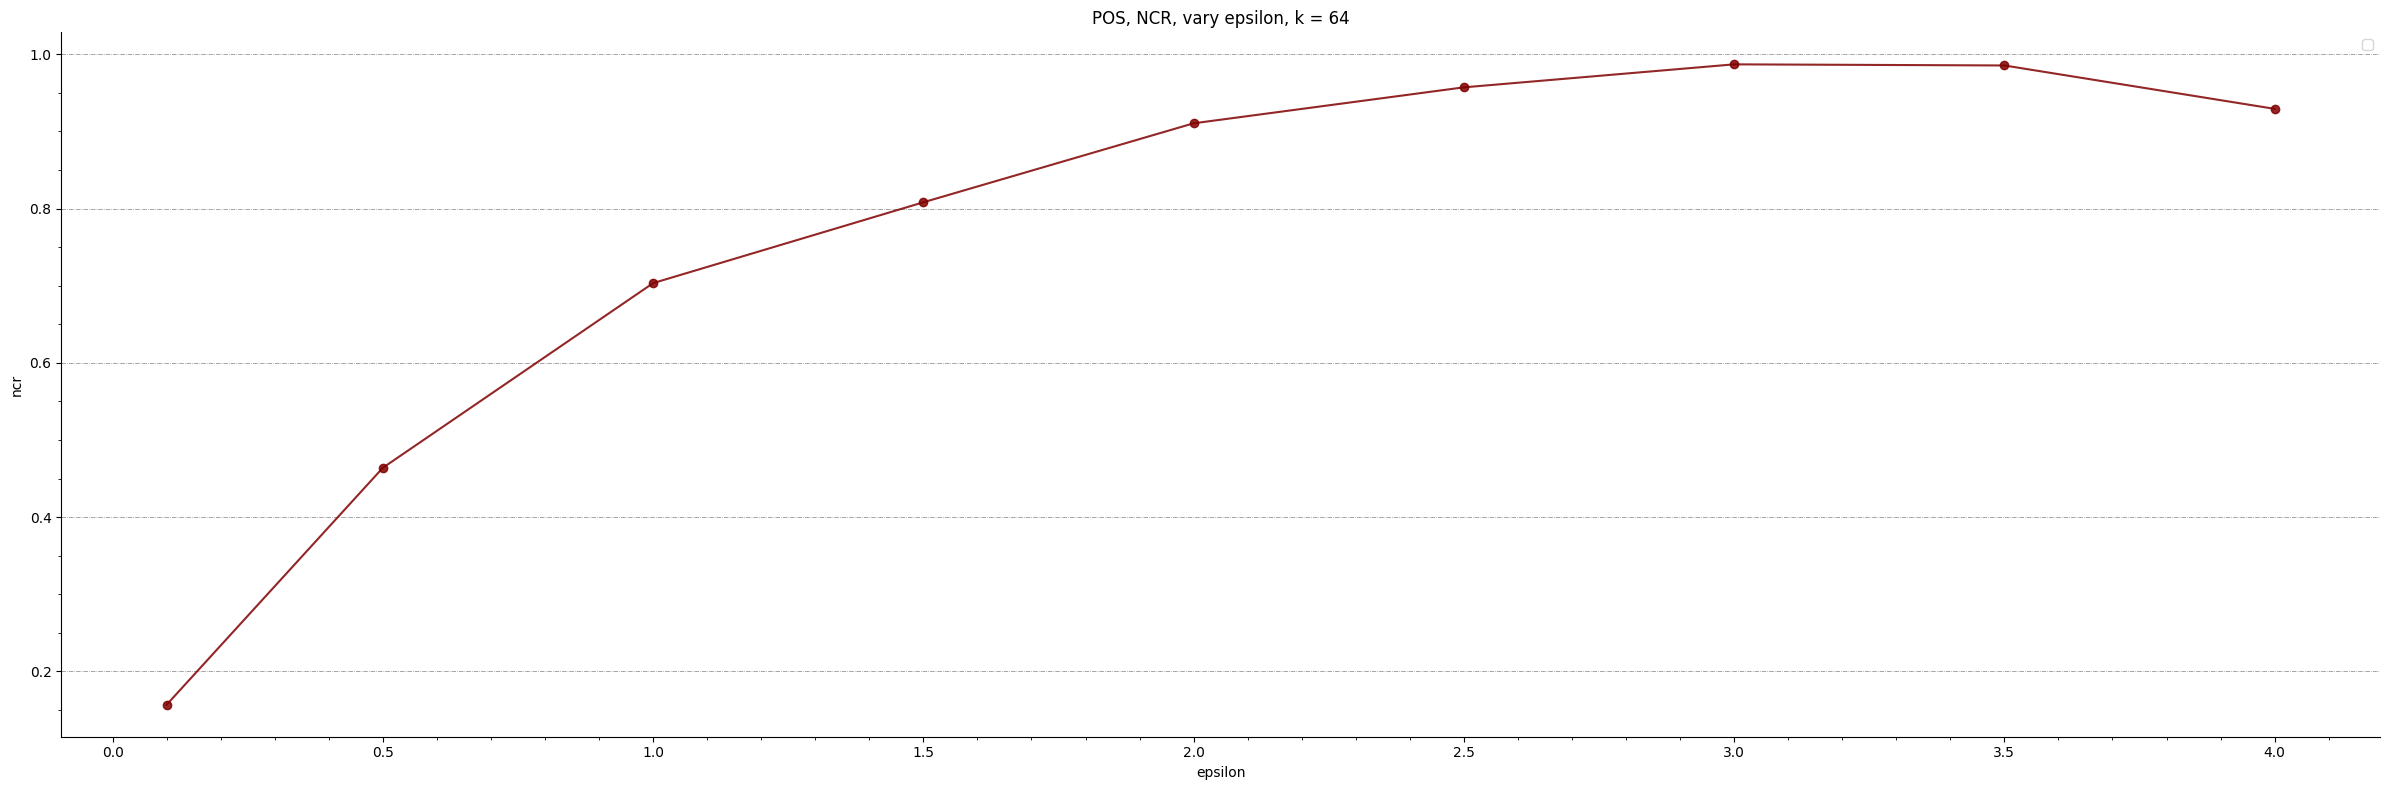

C:\Users\renan.oliveira\AppData\Local\Temp\ipykernel_13736\1143936976.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


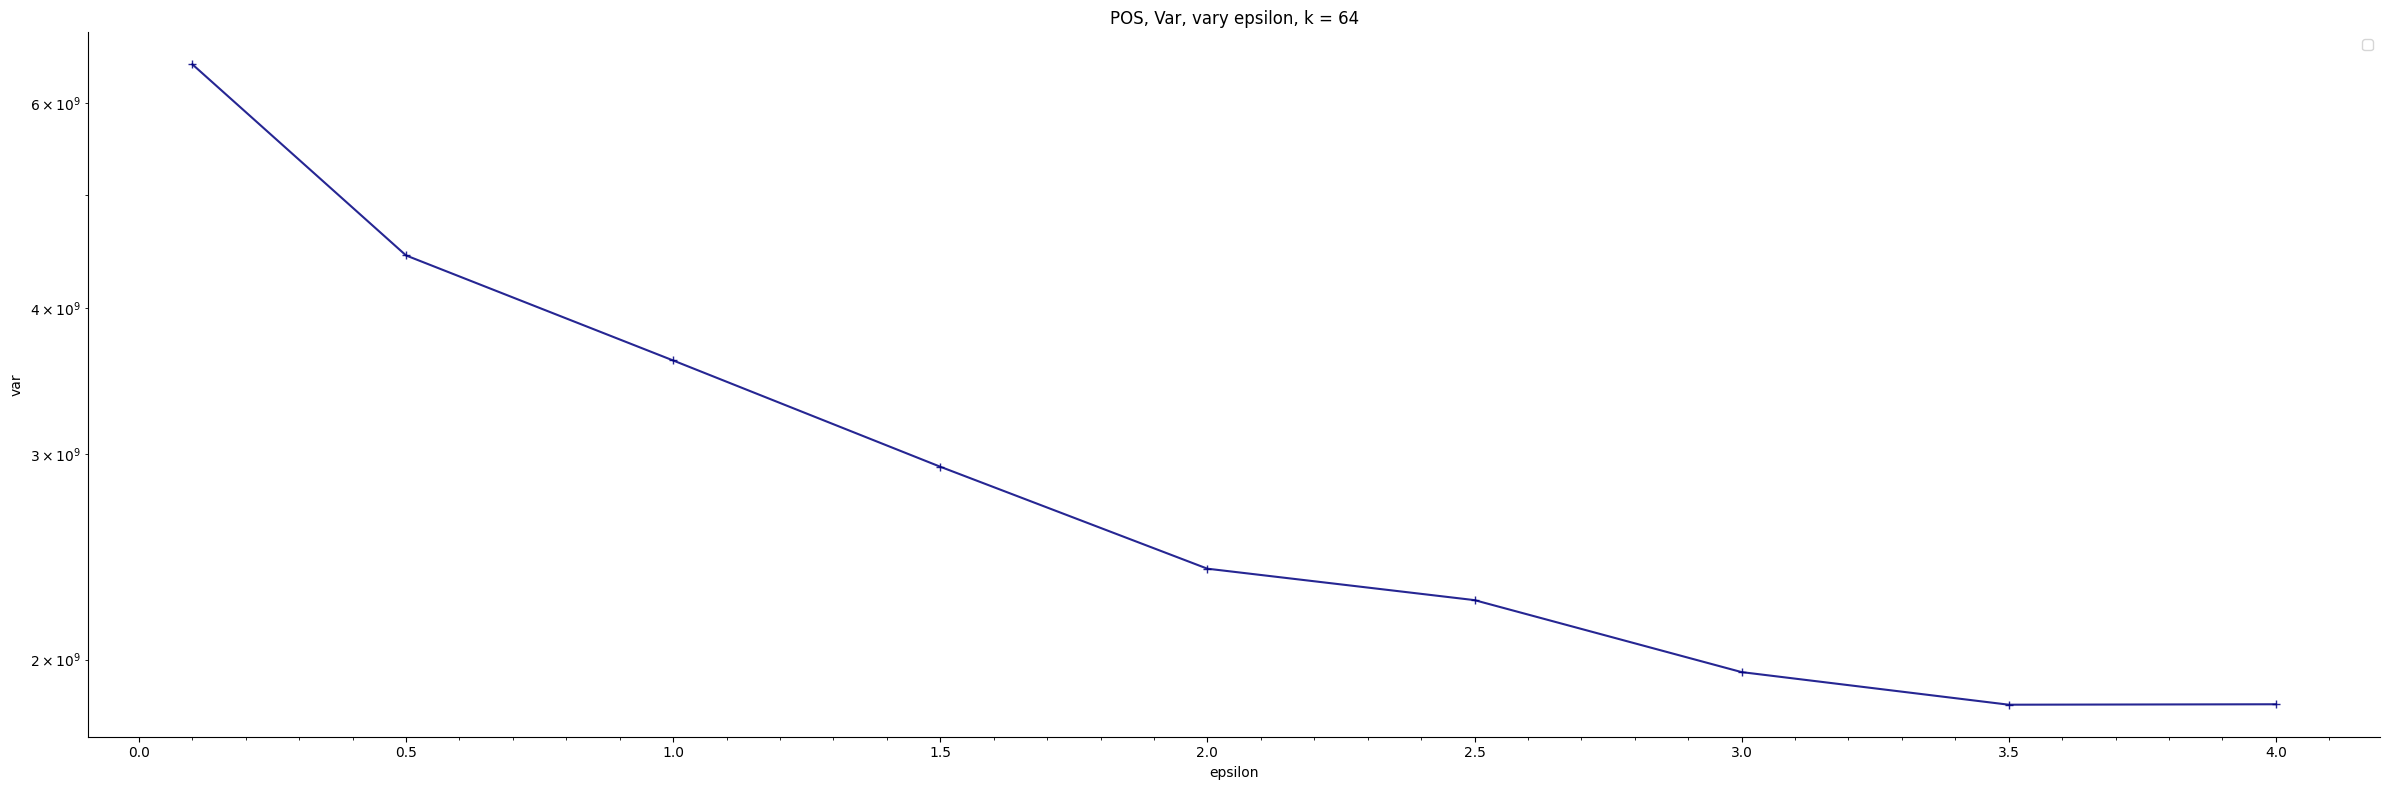

In [288]:
comparator(0.1, 4, 0.5, user_transactions_BMS, group_1, group_2, group_3, 64, domain, 1)

C:\Users\renan.oliveira\AppData\Local\Temp\ipykernel_13736\2220892354.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


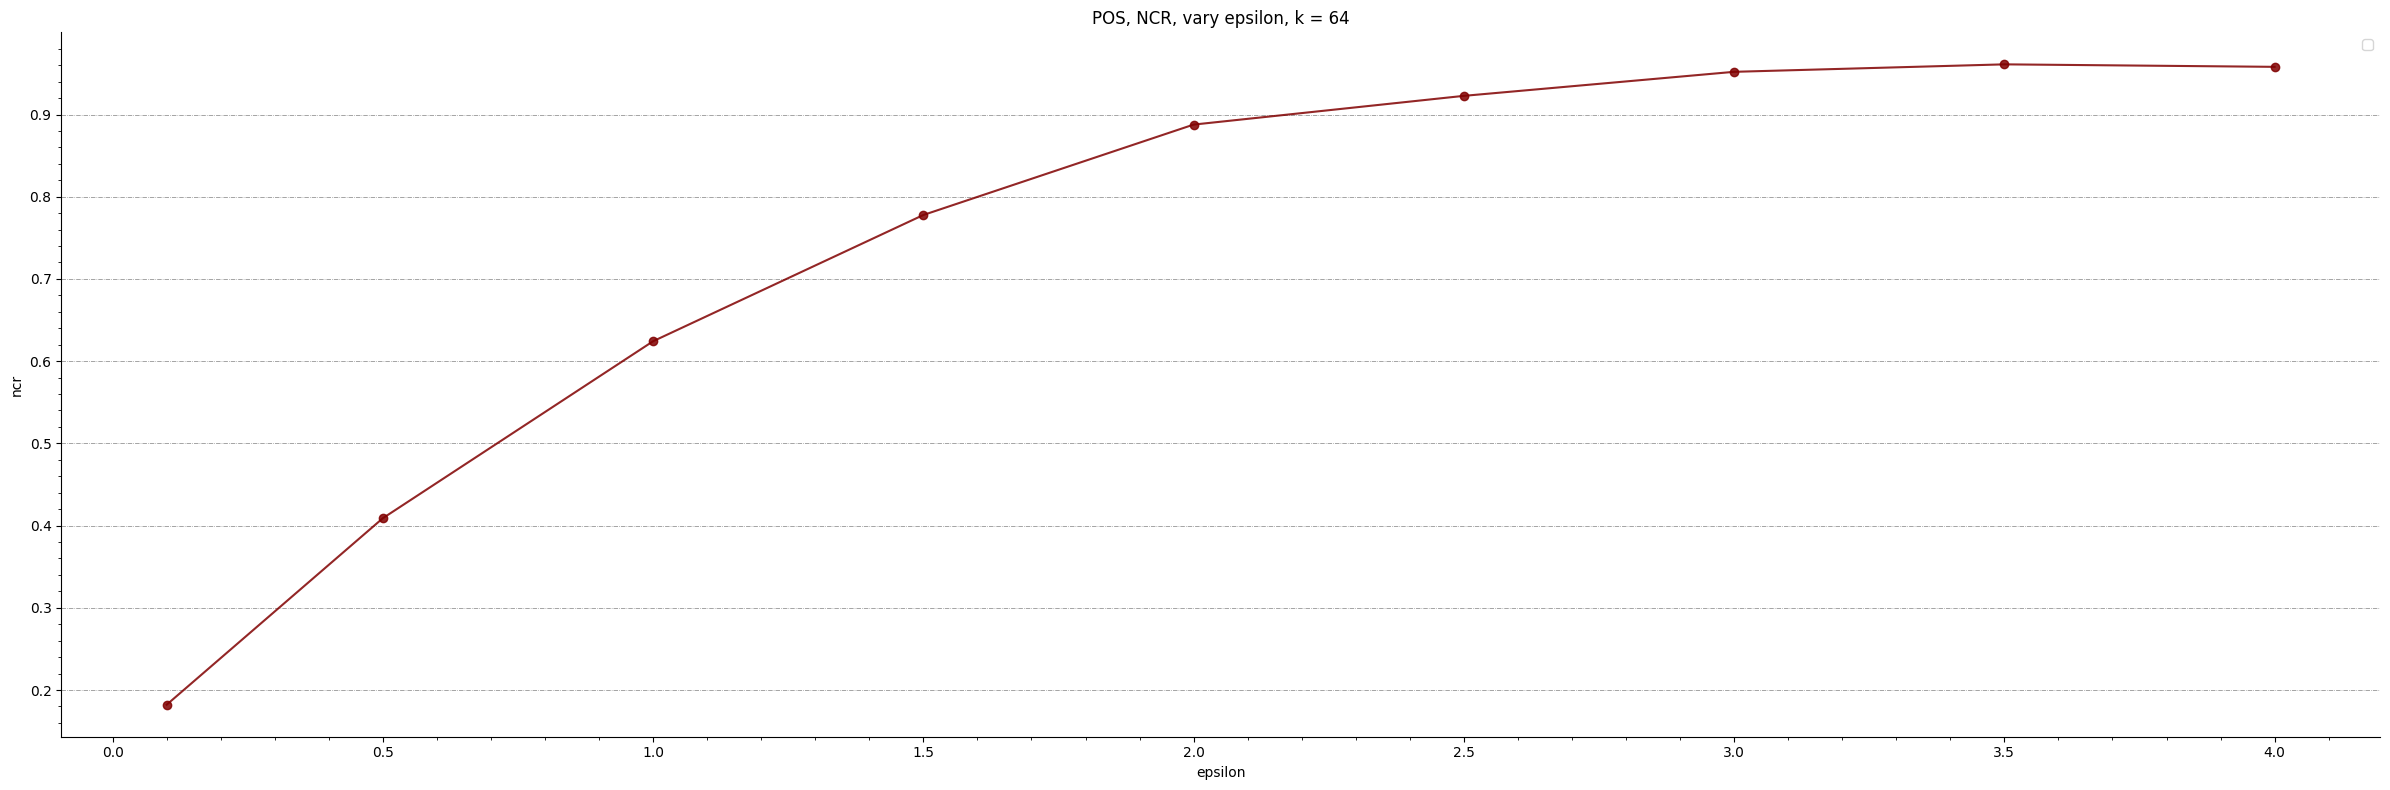

C:\Users\renan.oliveira\AppData\Local\Temp\ipykernel_13736\2220892354.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


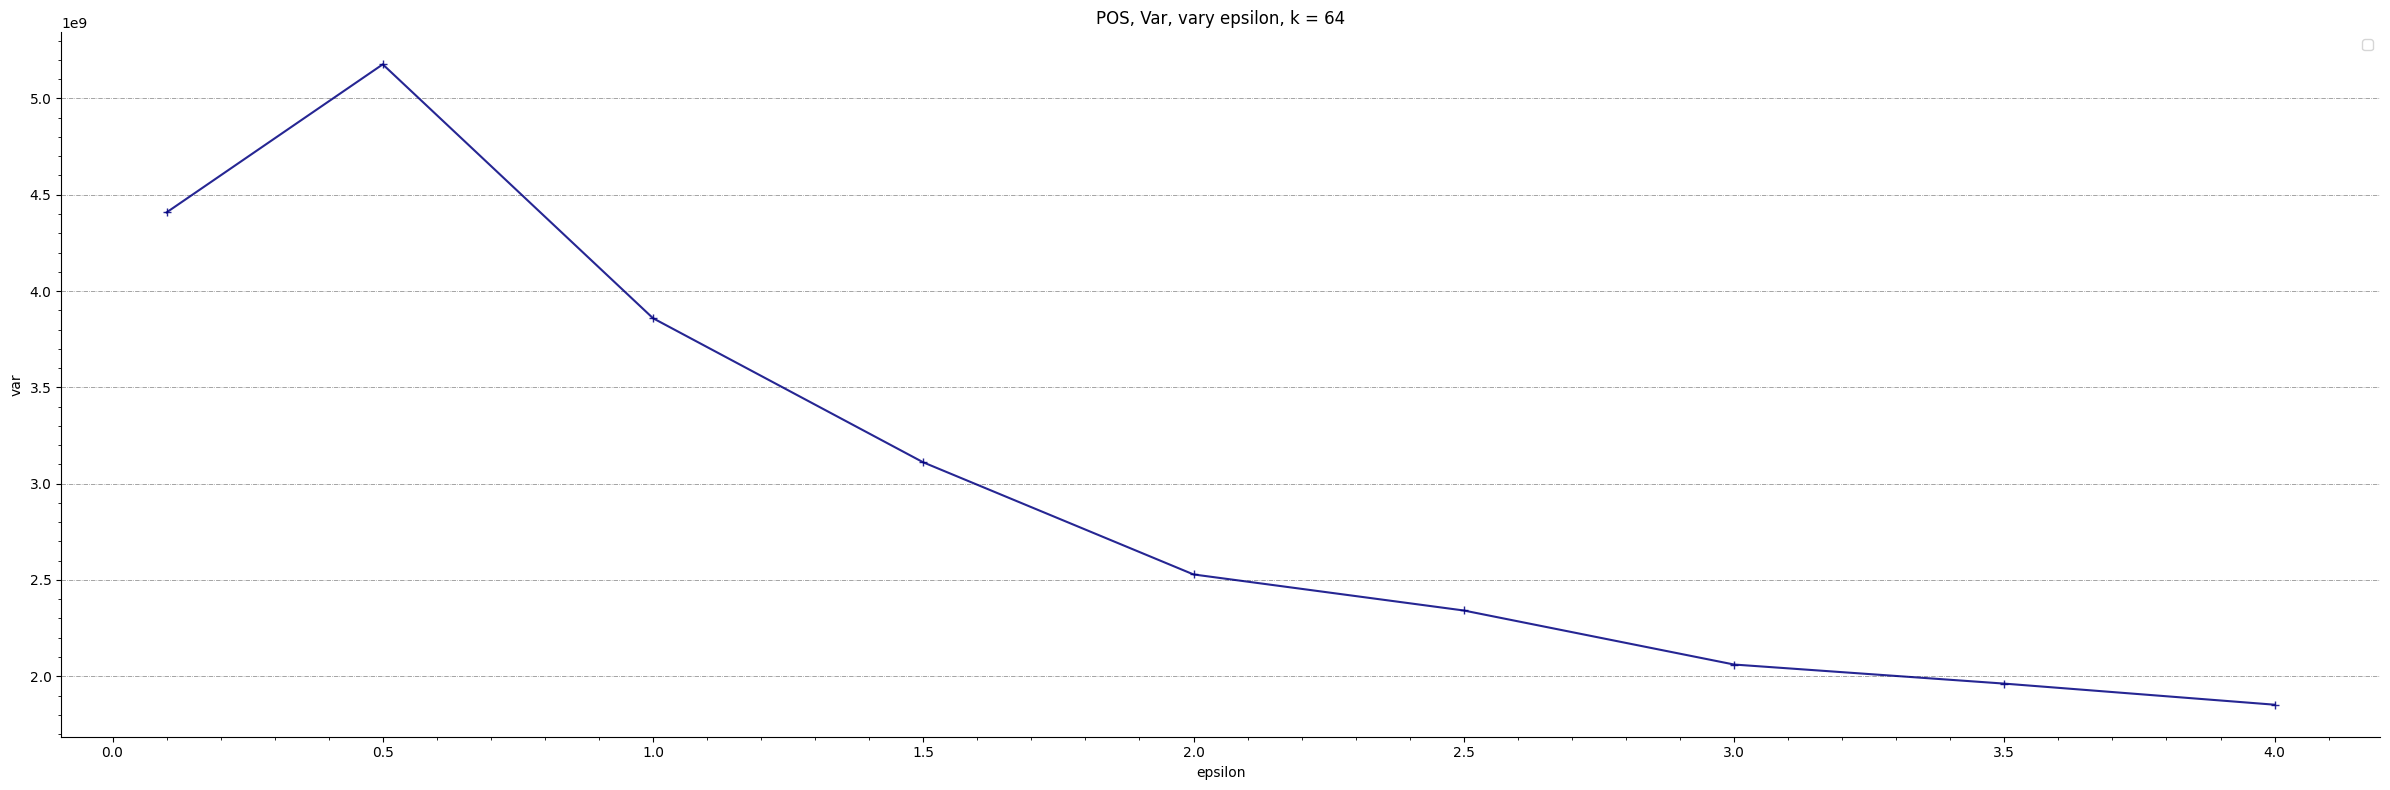

In [286]:
comparator(0.1, 4, 0.5, user_transactions_BMS, group_1, group_2, group_3, 64, domain, 10)